In [1]:
# import nltk
# nltk.download('all')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import string, re, emoji
import random

# Limpieza de textos
from pattern.text.en import singularize, lemma
from nltk.corpus import stopwords
from wordcloud import WordCloud

from transformers import BertTokenizer,BertModel, AdamW, get_linear_schedule_with_warmup
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import plot_model
import tensorflow
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch


from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

pd.options.display.max_rows = None
import time

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga de datos

In [3]:
'''
  id - a unique identifier for each tweet
  text - the text of the tweet
  location - the location the tweet was sent from (may be blank)
  keyword - a particular keyword from the tweet (may be blank)
  target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)
'''
train = pd.read_csv('./train.csv', encoding='utf8')
test = pd.read_csv('./test.csv', encoding='utf8')

cachedStopWords = stopwords.words('english')

# Analisis Exploratorio I

<AxesSubplot:>

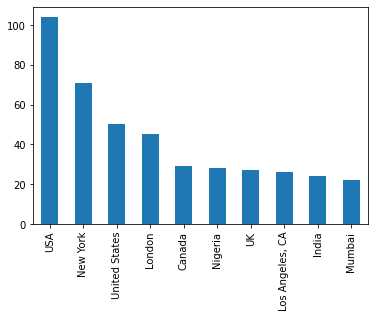

In [4]:
train['location'].value_counts().head(10).plot.bar()

<AxesSubplot:>

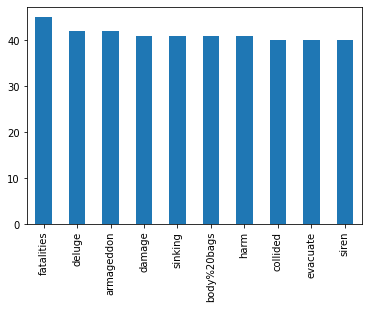

In [5]:
train['keyword'].value_counts().head(10).plot.bar()

<AxesSubplot:>

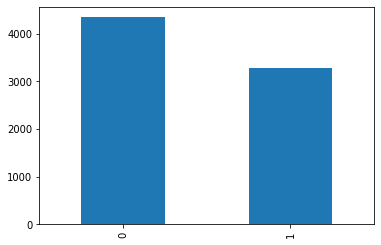

In [6]:
train['target'].value_counts().plot.bar()

In [7]:
train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
5       #RockyFire Update => California Hwy. 20 closed...
6       #flood #disaster Heavy rain causes flash flood...
7       I'm on top of the hill and I can see a fire in...
8       There's an emergency evacuation happening now ...
9       I'm afraid that the tornado is coming to our a...
10            Three people died from the heat wave so far
11      Haha South Tampa is getting flooded hah- WAIT ...
12      #raining #flooding #Florida #TampaBay #Tampa 1...
13                #Flood in Bago Myanmar #We arrived Bago
14      Damage to school bus on 80 in multi car crash ...
15                                         What's up man?
16                                          I love fruits
17            

# Limpieza de datos

In [8]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Location

In [9]:
def cleanCountry(value):
  try:

    if (
      'nan' in value or
      'world' in value or
      'global' in value or
      'everywhere' in value or
      'earth' in value or
      'ss' in value or
      '?' in value or
      re.search(r"[0-9]+", value, re.I)
    ):
      return 'unknow'

    if (
      'italy' in value
    ):
      return 'italy'

    if (
      'india' in value or
      'mumbai' in value
    ):
      return 'india'
    
    if (
      'switzerland' in value or
      'geneva' in value
    ):
      return 'switzerland'
    
    if (
      'china' in value or
      'hong kong' in value
    ):
      return 'china'

    if (
      'nigeria' in value or
      'lagos' in value
    ):
      return 'nigeria'

    if (
      'japan' in value or
      'tokyo' in value
    ):
      return 'japan'

    if (
      'ontario' in value or
      'canada' in value or
      'toronto' in value or
      'calgary' in value or
      'alberta' in value or
      re.search(r"ab$", value, re.I) or
      re.search(r"bc$", value, re.I)
    ):
      return 'canada'

    if (
      'uk' == value or
      'united kingdom' in value or
      'kingdom' in value or
      'british' in value or
      'scotland' in value or
      'newcastle' in value or
      'england' in value or
      'london' in value or
      re.search(r"uk$", value, re.I)
    ):
      return 'uk'

    if (
      'nyc' == value or
      'nj' == value or
      'united states' in value or
      'new york' in value or
      'san francisco' in value or
      'los angeles' in value or
      'new jersey' in value or
      'north carolina' in value or
      'st. louis' in value or
      'kansas city' in value or
      'san diego' in value or
      'las vegas' in value or
      'sacramento' in value or
      'oregon' in value or
      'michigan' in value or
      'manchester' in value or
      'portland' in value or
      'texas' in value or
      'u.s.' in value or
      'philippines' in value or
      'nevada' in value or
      'us' in value or
      'arizona' in value or
      'lincoln' in value or
      'wisconsin' in value or
      'pennsylvania' in value or
      'seattle' in value or
      'usa' in value or
      'washington' in value or
      'florida' in value or
      'chicago' in value or
      'california' in value or
      'nashville' in value or
      'colorado' in value or
      'denver' in value or
      'cleveland' in value or
      'atlanta' in value or
      'massachusetts' in value or
      'boston' in value or
      'oklahoma' in value or
      'tennessee' in value or
      'liverpool' in value or
      'phoenix' in value or
      'baltimore' in value or
      re.search(r"nyc$", value, re.I) or
      re.search(r"hi$", value, re.I) or
      re.search(r"va$", value, re.I) or
      re.search(r"ks$", value, re.I) or
      re.search(r"la$", value, re.I) or
      re.search(r"ak$", value, re.I) or
      re.search(r"md$", value, re.I) or
      re.search(r"mo$", value, re.I) or
      re.search(r"wi$", value, re.I) or
      re.search(r"az$", value, re.I) or
      re.search(r"ga$", value, re.I) or
      re.search(r"ok$", value, re.I) or
      re.search(r"nj$", value, re.I) or
      re.search(r"wa$", value, re.I) or
      re.search(r"pa$", value, re.I) or
      re.search(r"ma$", value, re.I) or
      re.search(r"co$", value, re.I) or
      re.search(r"oh$", value, re.I) or
      re.search(r"il$", value, re.I) or
      re.search(r"tn$", value, re.I) or
      re.search(r"dc$", value, re.I) or
      re.search(r"ca$", value, re.I) or
      re.search(r"tx$", value, re.I) or
      re.search(r"nc$", value, re.I) or
      re.search(r"fl$", value, re.I) or
      re.search(r"ny$", value, re.I)
    ):
      return 'usa'

    return value
  except:
    return 'unknow'

train['location'] = train['location'].apply(lambda row: str(row).lower())
train['location'] = train['location'].apply(lambda row: cleanCountry(row))

## Keyword

In [10]:
def toSingular(value):
  try:
    return singularize(value)
  except:
    return value

def parseLemma(value):
  try:
    return lemma(value)
  except:
    return value

def replaceSpace(value):
  return str(value).replace('%20', ' ')

train['keyword'] = train['keyword'].apply(lambda row: toSingular(row))
train['keyword'] = train['keyword'].apply(lambda row: parseLemma(row))
train['keyword'] = train['keyword'].apply(lambda row: replaceSpace(row))
train['keyword'].value_counts()

flood                  109
body bag               107
scream                 105
drown                  104
bomb                   101
fatality                82
sink                    80
weapon                  78
wreck                   76
evacuate                76
death                   74
collide                 74
derail                  73
blaze                   72
explode                 71
injury                  71
quarantine              71
attack                  71
panic                   70
deluge                  69
riot                    69
collapse                69
destroy                 69
siren                   69
casualty                69
suicide bomb            68
hostage                 68
crush                   68
crash                   67
burn                    67
electrocute             66
survive                 65
hijack                  65
demolish                62
obliterate              62
nan                     61
rescue                  57
f

## Text

In [11]:
def removeHastags(value):
  if ('#' not in value): return value
  hashtags = re.findall(r"#[^\s]*", value, re.I)
  for hashtag in hashtags:
    value = value.replace(hashtag, '')
  return value

def removeLinks(value):
  if ('http' not in value): return value
  links = re.findall(r"http[^\s]*", value, re.I)
  for link in links:
    value = value.replace(link, '')
  return value

def removeStepWords(value):
  return ' '.join([word for word in value.split() if word not in cachedStopWords])

def extractEmojis(value):
  items = value.split(' ')
  emojis = ''.join(item for item in items if item in emoji.EMOJI_DATA)

  if (len(emojis) > 0): print(value)

  return value

def sentenceToSingular(value):
  items = value.split(' ')
  for item in items:
    singular = toSingular(item)
    value = value.replace(item, singular)
  return value

def sentenceToPresent(value):
  items = value.split(' ')
  for item in items:
    present = parseLemma(item)
    value = value.replace(item, present)
  return value

translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

cleanText = []
for index, row in train.iterrows():
  text = row['text'][:]

  # Limpiando el texto
  text = text.lower()                         # Convierte todo a minusculas
  text = text.replace('utc', '')              # Quita utc
  text = text.replace('#', '')                # Quita #
  text = text.replace('@', '')                # Quita @
  text = removeLinks(text)                    # Quita links
  text = extractEmojis(text)                  # Quita todos los emojis
  text = text.translate(translator)           # Quita todos los signos de puntuacion
  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas
  text = sentenceToSingular(text)             # Pasa las palabras a singular
  text = sentenceToPresent(text)              # Pasa las palabras a presente
  
  numbers = re.findall(r"[0-9]", text, re.I)
  if (len(numbers) > 0):
    for number in numbers:
      if (number == '911'): continue

      # Quitando numeros
      text = text.replace(number, '')

  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas

  cleanText.append(text)

train['text'] = cleanText[:]

In [12]:
for index, row in train.iterrows():
  print(row['text'])

deed reason earthquake may allah forgive u
forest fire near la ronge sask canada
resident ask shelter place notify officer evacuation shelter place order expect
person receive wildfire evacuation order californium
get send photo ruby alaska smoke wildfire pour school
rockyfire update californium hwy close direction due lake county fire cafire wildfire
flood disaster heavy rain cause flash flood street manitou colorado spring area
top hill see fire wood
emergency evacuation happen build acro street
afraid tornado come area
three person die heat wave far
haha south tampa get flood hah wait second live south tampa gonna gonna fvck flood
rain flood florida tampabay tampa day lose count
flood bago myanmar arrive bago
damage school bu multu car crash break
man
love fruit
summer lovely
car fast
goooooooaaaaaal
ridiculou
london cool
love ski
wonderful day
looooool
way eat shit
nyc last week
love girlfriend
cooool
like pastum
end
bbcmtd wholesale market ablaze
alway try bring heavy metal rt
afr

# Analisis Exploratorio II

<AxesSubplot:>

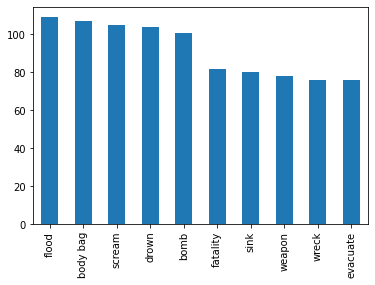

In [13]:
train['keyword'].value_counts().head(10).plot.bar()

<AxesSubplot:>

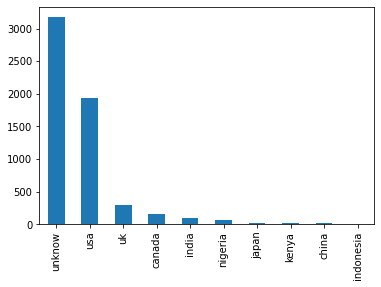

In [14]:
train['location'].value_counts().head(10).plot.bar()

<AxesSubplot:>

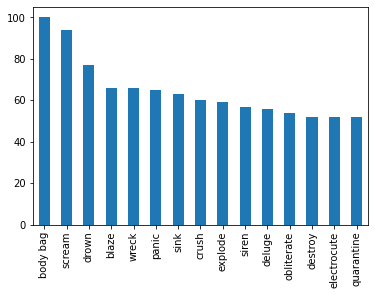

In [15]:
train.loc[train['target'] == 0]['keyword'].value_counts().head(15).plot.bar()

<AxesSubplot:>

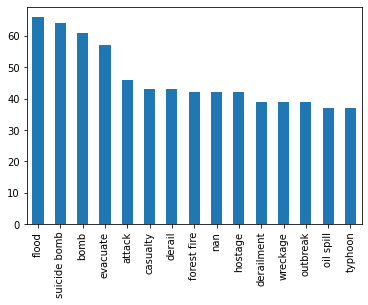

In [16]:
train.loc[train['target'] == 1]['keyword'].value_counts().head(15).plot.bar()

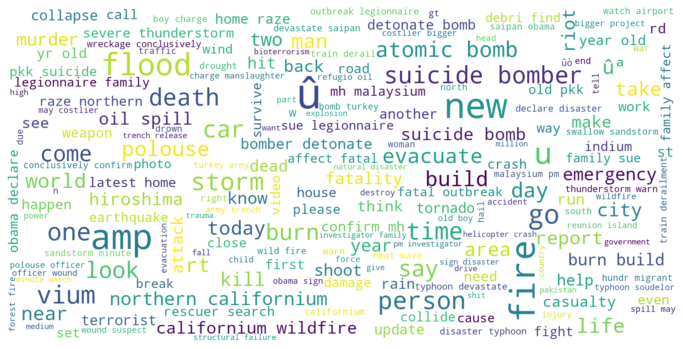

In [17]:
#Disaster Tweets wordcloud 
disaster_tweets = train[train['target'] == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

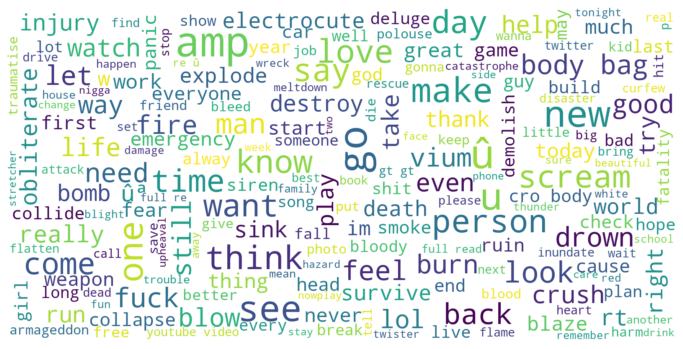

In [18]:
# Positive tweets wordcloud
formal_tweets = train[train["target"] == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Clasificando tweets

In [31]:
def classifyTweet(dfToClassify):
    subjectivityValues = []
    positiveValues = []

    for text in dfToClassify.text:
        sent = TextBlob(text)
        subjectivity  = sent.sentiment.subjectivity

        sent = TextBlob(text, analyzer = NaiveBayesAnalyzer())
        classification= sent.sentiment.classification
        positiveScore = sent.sentiment.p_pos

        subjectivityValues.append(subjectivity)
        positiveValues.append(positiveScore)
    
    return [subjectivityValues, positiveValues]

In [32]:
tweetsClassification = pd.DataFrame(train[0:5])

In [33]:
subjectivityValues, positiveValues = classifyTweet(tweetsClassification)
tweetsClassification['Subjectivity'] = subjectivityValues
tweetsClassification['Positive'] = positiveValues

In [34]:
tweetsClassification.head()

,id,keyword,location,text,target,Subjectivity,Positive
0,1,nan,unknow,deed reason earthquake may allah forgive u,1,0.0,0.617496
1,4,nan,unknow,forest fire near la ronge sask canada,1,0.4,0.493763
2,5,nan,unknow,resident ask shelter place notify officer evac...,1,0.0,0.730243
3,6,nan,unknow,person receive wildfire evacuation order calif...,1,0.0,0.455473
4,7,nan,unknow,get send photo ruby alaska smoke wildfire pour...,1,0.0,0.218477


# BERT 

#### Separando train y test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train.text.values, train.target.values, test_size=0.1, random_state=2020)

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [37]:
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sentence in data:
        encoded_sentence = tokenizer.encode_plus(
            text=sentence,
            add_special_tokens=True,       
            max_length=MAX_LEN,                  
            pad_to_max_length=True,         
            return_attention_mask=True     
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sentence.get('input_ids'))
        attention_masks.append(encoded_sentence.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


#### Concatenando y codificando train y test

In [38]:
all_tweets = np.concatenate([train.text.values, test.text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

#### preprocessing_for_bert en X_train y X_test

In [39]:
MAX_LEN = 64

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\transformers\tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Construyendo el modelo

In [40]:
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

test_data = TensorDataset(val_inputs, val_masks, test_labels)
test_sampler = SequentialSampler(test_data)
loader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

## Entrenamiento del modelo

In [41]:
class BertClassifier(torch.nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 2)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits


In [42]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [43]:
def initialize_model(epochs=4):
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,
                      eps=1e-8 
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

## Precision y perdida

In [44]:
# Specify loss function
loss_fn = torch.nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [45]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, loader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is de

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


### Validando data de prueba

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, loader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, test_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

## Prediccion

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test.text)

# Create the DataLoader for our test set
test_dataset  = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset )
test_dataloader  = DataLoader(test_dataset , sampler=test_sampler, batch_size=32)

## Comprobando las predicciones

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

## Negativos

In [ ]:
negativeResult = test[preds==1]

subjectivityValues, positiveValues = classifyTweet(negativeResult)
negativeResult['Subjectivity'] = subjectivityValues
negativeResult['Positive'] = positiveValues

negativeResult.head()